In [8]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.models.resnet import ResNet, BasicBlock
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from torch.utils.data import DataLoader,Dataset
import torchvision.utils
import numpy as np
import random
from PIL import Image
import PIL.ImageOps
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.autonotebook import tqdm as tqdm_jupyter
from tqdm import tqdm as tqdm_bash
import inspect
import os
import time
from siamese_tools import *
import matplotlib.pyplot as plt
import matplotlib

In [9]:
def dist(tens1,tens2,scalar=1):
    tens1 = (tens1.type(torch.cuda.DoubleTensor)*scalar).cpu().numpy().astype(np.longdouble)
    tens2 = (tens2.type(torch.cuda.DoubleTensor)*scalar).cpu().numpy().astype(np.longdouble)
    sub = tens1-tens2
    sqr = np.power(sub,2)
    s = np.sum(sqr,axis=1)
    dis = np.power(s,0.5)
    return dis

# Settings for Validation
## Base CNN

In [10]:
model_name = "skw.base_cnn.v1"
epochs = 20
batch_size = 64
pbar_type = "jupyter"
image_type = "L"
model_path = os.path.join("models",model_name+".ep_"+str(epochs),"epoch_19.pt")
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()])
model_class = SiameseNetwork

## Base ResNet

In [11]:
model_name = "skw.base_resnet.v1"
epochs = 20
batch_size = 64
pbar_type = "jupyter"
image_type = "RGB"
model_path = os.path.join("models",model_name+".ep_"+str(epochs),"epoch_19.pt")
transformation = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
model_class = SiameseResNet

In [12]:
root_dir = "data"
test_dir = os.path.join(root_dir,"test")

im_test_dset = dset.ImageFolder(root=test_dir)

val_siamese_dset = SiameseDataset(imageFolderDataset=im_test_dset, transform=transformation,depth=image_type)
val_loader = DataLoader(val_siamese_dset,shuffle=True,num_workers=0,batch_size=batch_size)

loss_function = ContrastiveLoss()
print("CUDA availability:",torch.cuda.is_available())
print("Using model:", model_path)

CUDA availability: True
Using model: models\skw.base_resnet.v1.ep_20\epoch_19.pt


In [13]:
model = model_class()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
val_batches = len(val_loader)

preds = np.array([])
lbls = np.array([])

model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

loss_function = ContrastiveLoss()

if torch.cuda.is_available():
    torch.cuda.empty_cache()

total_loss = 0
with torch.no_grad():
    progress = None
    if pbar_type == "bash":
        progress = tqdm_bash(enumerate(val_loader,0), total=val_batches, unit=" batch(es)", desc="Loss: ", position=0, leave=True)
    if pbar_type == "jupyter":
        progress = tqdm_jupyter(enumerate(val_loader,0), total=val_batches, unit=" batch(es)", desc="Loss: ")
    for i,data in progress:
        img0, img1 , label = data
        lbls = np.append(lbls,label.cpu().numpy())
        img0, img1 , label = img0.to(device), img1.to(device) , label.to(device)
        
        output1, output2 = model(img0,img1)
        euclidean_distance = dist(output1, output2)
        preds = np.append(preds,euclidean_distance)
        loss = loss_function(output1, output2,label)
        total_loss += loss.item()
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

        if torch.cuda.is_available():
            torch.cuda.empty_cache()


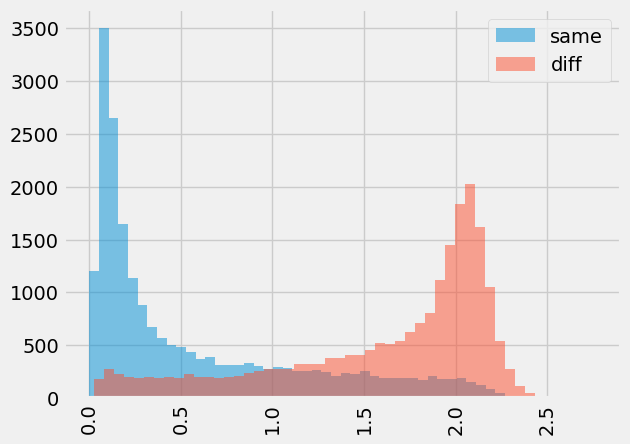

In [7]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use('fivethirtyeight')#'ggplot')

same = preds[lbls==0]
diff = preds[lbls==1]

bins = 50
plt.hist(same, bins, alpha=0.5, label='same')
plt.hist(diff, bins, alpha=0.5, label='diff')
plt.legend(loc='upper right')
plt.xticks(rotation='vertical')
plt.savefig(model_name+".ep_"+str(epochs)+".full_test"+".png")
plt.show()